### 신경망 (Neural Networks)
- 예제: 숫자 이미지를 분류하는 신경망(convnet)
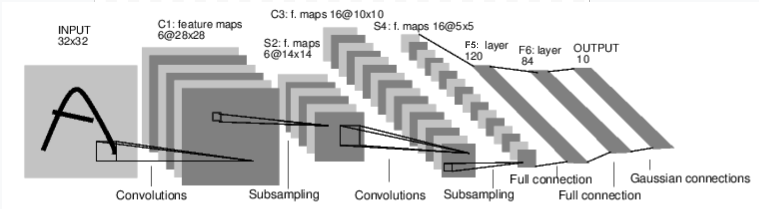
- 신경망의 일반적인 학습 과정
    - 학습 가능한 매개변수 (또는 가중치(weight))를 갖는 신경망을 정의
    - dataset 입력을 반복
    - 입력을 신경망에서 전파(process)
    - 손실(loss: 출력이 정답으로부터 얼마나 떨어져 있는지)을 계산
    - Gradient를 신경망의 매개변수들에 역으로 전파 (Backpropagation)
    - 신경망의 가중치를 갱신. 일반적으로 다음과 같은 간단한 규칙 사용   
        `새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)`

#### 신경망 정의하기

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        # 입력 이미지 채널 1개(흑백), 출력 채널 6개, 5x5 정사각 conv 행렬
        # convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 아핀(affine) 연산 : y = Wx + b -> 선형 변환 + 평행 이동
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):       # 설명용
        # Convolution Layer c1: 입력 이미지 채널 1, 출력 채널 6, 5x5 정사각 합성곱, 활성 함수 ReLU
        # (N, 6, 28, 28) 크기를 갖는 Tensor를 출력 (N은 batch size)
        c1 = F.relu(self.conv1(input))
        # Subsampling Layer s2: 2x2 격자
        # 어떤 매개변수도 가지지 않고 (N, 6, 14, 14) Tensor를 출력
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution Layer c3: 입력 채널 6, 출력 채널 16, 5x5 정사각 합성곱, 활성 함수 ReLU
        # (N, 16, 10, 10) 크기를 갖는 Tensor를 출력
        c3 = F.relu(self.conv2(s2))
        s4 = F.max_pool2d(c3, 2)    # s4 = F.max_pool2d(c3, (2, 2))와 같은 표현
        # Fully Connected Layer f5: (N, 400) Tensor를 입력으로 받아서 (N, 120) Tensor 출력, 활성 함수 ReLU
        f5 = F.relu(self.fc1(s4))
        f6 = F.relu(self.fc2(f5))
        output = self.fc3(f6)
        return output

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)    

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


`forward` 함수만 정의하고 나면, `backward` 함수는 `autograd`를 사용하여 자동으로 정의   
모델의 학습 가능한 매개변수들은 `net.parameters()`에 의해 반환

In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


임의의 32x32 입력값

In [3]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.1451,  0.1208, -0.0257,  0.0005,  0.0934, -0.1475,  0.0602, -0.1056,
          0.0965,  0.0121]], grad_fn=<AddmmBackward0>)


모든 매개변수의 변화도 버퍼(gradient buffer)를 0으로 설정하고, 무작위 값으로 역전파

In [4]:
net.zero_grad()
out.backward(torch.randn(1, 10))

요약   
    - `torch.Tensor` : `backward()`같은 autograd 연산을 지원하는 _다차원 배열_, tensor에 대한 gradient를 가짐   
    - `nn.Module` : 신경망 모듈. 매개변수를 캡슐화하는 간편한 방법으로, GPU로 이동 및 내보내기, 불러오기 등의 작업을 위한 헬퍼(helper) 제공   
    - `nn.Parameter` : Tensor의 한 종류, `Module`에 속성으로 할당될 때 자동으로 매개변수로 등록   
    - `autograd.Function` : autograd연산의 forward와 backward 정의 구현.   

#### 손실 함수 (Loss Function)
- (output, target)을 한 쌍(pair)의 입력으로 받아, 출력(output)이 정답(target)으로부터 얼마나 멀리 떨어져 있는지 추정하는 값을 계산
- 간단한 손실 함수의 예로는, 평균제곱오차(mean-squared error, MSE)를 계산하는 `nn.MSEloss`

In [5]:
output = net(input)
target = torch.randn(10) # dummy target
target = target.view(1, -1) # 출력과 같은 shape으로 변환
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.8362, grad_fn=<MseLossBackward0>)


#### 역전파 (Backpropagation)
- `loss.backward()`를 호출

In [6]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0024, -0.0145, -0.0025,  0.0117, -0.0044, -0.0051])


#### 가중치 갱신
- 가장 많이 사용되는 갱신 규칙 : `확률적 경사하강법(SGD: Stochastic Gradient Descent)`
    - 새로운 가중치 = 가중치 - 학습률 * 변화도
    - weight = weight - learning_rate * gradient

In [7]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

- `torch.optim` : SGD, Nesterov-SGD, Adam, RMSProp 등 다양한 갱신 규칙 있는 패키지

In [8]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()